In [53]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from starkhelium import *
from tqdm import trange, tqdm
import os
from scipy.constants import h, hbar, c, alpha, m_e, e, epsilon_0, atomic_mass, pi, physical_constants
a_0 = physical_constants['Bohr radius'][0]
E_h = physical_constants['Hartree energy'][0]

In [3]:
def get_sorted_nlm_vals(nmin, nmax):
    """ n, l and m vals for each matrix column, using range n_min to n_max.
    """
    n_rng = np.arange(nmin, nmax + 1)
    n_vals = np.array([], dtype='int32')
    l_vals = np.array([], dtype='int32')
    m_vals = np.array([], dtype='int32')
    for n in n_rng:
        l_rng = np.arange(0, n)
        for l in l_rng:
            m_rng = np.array( [[-i,i] for i in np.arange(l,0,-1)], dtype='int32' ).reshape(-1)
            m_rng = np.append(m_rng, 0)
            n_vals = np.append(n_vals, np.array(np.zeros_like(m_rng) + n))
            l_vals = np.append(l_vals, np.array(np.zeros_like(m_rng) + l))
            m_vals = np.append(m_vals, m_rng)
    return n_vals, l_vals, m_vals

In [4]:
def reorder_indicies(n_vals_1, L_vals_1, m_vals_1, n_vals_2, L_vals_2, m_vals_2):
    indicies = np.array([], dtype='int32')
    for i in range(len(n_vals_1)):
        for j in range(len(n_vals_2)):
            if n_vals_1[i] == n_vals_2[j] and L_vals_1[i] == L_vals_2[j] and m_vals_1[i] == m_vals_2[j]:
                indicies = np.append(indicies, j)   
                break
    return indicies

In [5]:
nmin = 3
nmax = 3
reorder_indicies( *(get_nlm_vals(nmin, nmax)), *(get_sorted_nlm_vals(nmin, nmax)) )

array([0, 1, 3, 2, 4, 6, 8, 7, 5])

In [6]:
# Between two nlm states
transition_dipole_moment = stark_int(n_1=50, n_2=51, l_1=0, l_2=1, m_1=0, m_2=0)
transition_dipole_moment

491.5268274202669

In [7]:
# In an electric field (with B=0)
# quantum numbers
nmin = 3
nmax = 3
S = 1
n_vals, L_vals, m_vals = get_nlm_vals(nmin, nmax)
J_vals = get_J_vals(S, L_vals, 1)
# quantum defects
neff = n_vals - get_qd(S, n_vals, L_vals, J_vals)
# energy levels
En = W_n(S, n_vals, L_vals, J_vals)
# field orientation
field_orientation = 'parallel'
# field-free Hamiltonian
H_0 = np.diag(En)
# find the off-diagonal terms of the Stark interaction matrix
mat_S = stark_matrix(neff, L_vals, m_vals, b_field=True, field_orientation=field_orientation)

calculate Stark terms: 100%|█████████████████████| 9/9 [00:00<00:00, 12.72it/s]


In [8]:
mat_S

array([[ 0.        ,  6.4980455 ,  6.4980455 , -6.4980455 ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 6.4980455 ,  0.        ,  0.        ,  0.        ,  6.42224398,
         4.54121227, -2.62187013,  0.        ,  0.        ],
       [ 6.4980455 ,  0.        ,  0.        ,  0.        ,  0.        ,
         4.54121227,  5.24374025, -4.54121227,  0.        ],
       [-6.4980455 ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  2.62187013,  4.54121227, -6.42224398],
       [ 0.        ,  6.42224398,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  4.54121227,  4.54121227,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -2.62187013,  5.24374025,  2.62187013,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -4.54121227,  4.54121227,  0

In [8]:
# specify the electric field
field = np.linspace(0.00, 10**7, 101) # V /cm
field_au = field * 100 * e * a_0 / En_h
# specify the magnetic field (in Telsa)
B_z = 0.001E-3
# (in atomic units)
B_z_au = B_z / (2.35*10**5)
# Zeeman interaction Hamiltonian
H_Z = np.diag(E_zeeman(m_vals, B_z_au))
# diagonalise for each field
eig_vals, eig_vecs = stark_map_vec(H_0, mat_S, field_au, H_Z=H_Z)

diagonalise Hamiltonian: 100%|████████████| 101/101 [00:00<00:00, 11221.85it/s]


In [9]:
# Re-order eig_vals and eig_vecs
indicies = reorder_indicies( *(get_nlm_vals(nmin, nmax)), *(get_sorted_nlm_vals(nmin, nmax)) )
eig_vecs_ord = eig_vecs[:,indicies]
eig_vecs_ord = eig_vecs_ord[:,:,indicies]
eig_vals_ord = eig_vals[:,indicies]

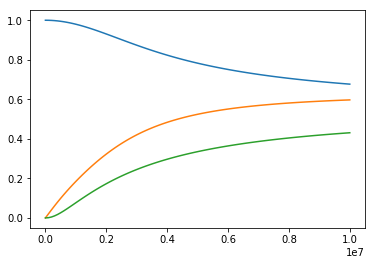

In [10]:
plt.plot(field, np.abs(eig_vecs_ord[:,0,[0,2,6]]))

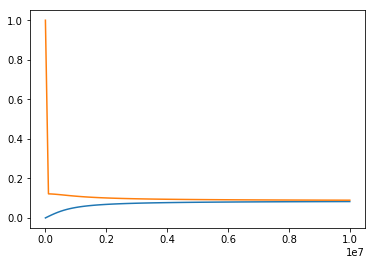

In [11]:
plt.plot(field, np.abs(eig_vecs_ord[:,7,[3,7]]))

 nval = nmin;                            % value of n
 mval = 0;                            % initial value of m
 dm = 1;
 
ellval = 0:1:nval-1;                 % values of l 
 qval = ellval.*0;                    % set of quantum defects

    for idx1 = 1:length(ellval)       % The quantum defects for all values of l
        qval(idx1) = fn_He_triplet_defects_Drake(nval,ellval(idx1));
    end
    
TM = zeros(length(ellval),3);                              % transition moments
TMidx = 0;

for idx2 = 1:length(ellval)           % range of possible ell values of initial state
        for idx3 = 1:length(ellval)   % range of possible ell values of final state
            if (abs(ellval(idx3) - ellval(idx2)) == 1) && (ellval(idx3) >= mval+dm)
                TMidx = TMidx + 1;
                TM(TMidx,1) = ellval(idx2);
                TM(TMidx,2) = ellval(idx3);
                TM(TMidx,3) = fn_angint(ellval(idx2),ellval(idx3),mval,mval+dm)*fn_numerov_He(nval-qval(idx2),nval-qval(idx3),ellval(idx2),ellval(idx3),1,corepole);
            end
        end
end

In [20]:
ellval = np.arange(0, nmin)
TM = np.zeros([len(ellval), 3])
TMidx = 0

for idx2 in np.arange(0, len(ellval)):
    for idx3 in np.arange(0, len(ellval)):
        if ( np.abs(ellval[idx2] - ellval[idx3]) == 1 ) and ( ellval[idx3] >= 1 ):
            
            TM[TMidx, 0] = ellval[idx2]
            TM[TMidx, 1] = ellval[idx3]
            TM[TMidx, 2] = stark_int(nmin, nmin, ellval[idx2], ellval[idx3], 0, 1)
            TMidx += 1
TM

array([[ 0.        ,  1.        , -7.39062727],
       [ 1.        ,  2.        , -4.50281829],
       [ 2.        ,  1.        ,  2.59970335]])

In [33]:
I = np.zeros(len(field))
statei = 0
statef = 7

for k, F in enumerate(field):
    
    Vi = eig_vecs[k,statei]
    Vf = eig_vecs[k,statef]
    
    for from_i in np.where(m_vals==0)[0]:
        
        for to_i in np.where(m_vals==1)[0]:
            if k==0: print('from:',from_i); print('to:',to_i)
            if np.abs(L_vals[from_i] - L_vals[to_i]) == 1:
                for TM_i in range(len(TM[:,0])):
                    if (TM[TM_i,1] == from_i) and (TM[TM_i,2] == to_i):
                        I[k] += Vi(from_i) * Vf(to_i) * TM(TM_i,3);
I

from: 0
to: 3
from: 0
to: 7
from: 2
to: 3
from: 2
to: 7
from: 6
to: 3
from: 6
to: 7


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [28]:
eig_vecs[1,0]

array([  9.99787122e-01,  -1.89630750e-08,  -1.89631405e-08,
         2.05977284e-02,   4.37798051e-16,   8.71147201e-17,
        -8.03796542e-10,  -8.03782417e-10,  -1.20209696e-03])

## Transition dipole moment between two states

State 1: 		 n= 3 , l= 0 , m= 0
State 2: 		 n= 3 , l= 2 , m= -1


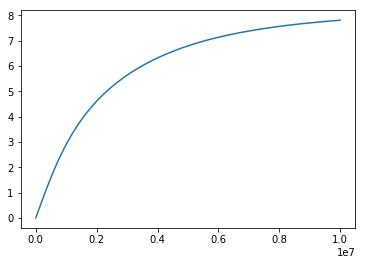

In [26]:
state_1 = 0
state_2 = 5
print('State 1: \t\t n=', n_vals[state_1], ', l=', L_vals[state_1], ', m=', m_vals[state_1])
print('State 2: \t\t n=', n_vals[state_2], ', l=', L_vals[state_2], ', m=', m_vals[state_2])

transition_dipole_moment = []
for i, f in enumerate(field):
    weightings = np.abs( np.outer( eig_vecs_ord[i,state_1], eig_vecs_ord[i,state_2] ) )
    transition_dipole_moment.append( np.sum( mat_S * weightings ) )

plt.plot(field, transition_dipole_moment)

## State character of a state

State: 		 n= 7 , l= 0 , m= 0
Character: 	 n= 7 , l= 1 , m= 1


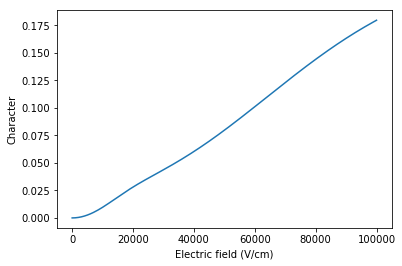

In [19]:
state = 5**2 + 6**2 + 0
character = 5**2 + 6**2 + 3
print('State: \t\t n=', n_vals[state], ', l=', L_vals[state], ', m=', m_vals[state])
print('Character: \t n=', n_vals[character], ', l=', L_vals[character], ', m=', m_vals[character])

plt.plot(field, np.abs(eig_vecs[:,state,character]**2))
plt.xlabel('Electric field (V/cm)')
plt.ylabel('Character')

## Stark map

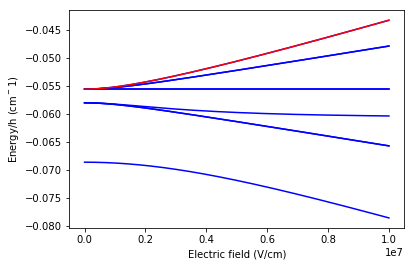

In [90]:
for i in np.arange(0, len(eig_vals[0]), 1): 
    plt.plot(field, eig_vals[:,i], '-b')
    
for i in np.where(m_vals==2): 
    plt.plot(field, eig_vals[:,i], '-r')
    
plt.xlabel('Electric field (V/cm)')
plt.ylabel('Energy/h (cm$^-1$)')

## L character of a state

State: 		 n= 7 , l= 2 , m= 0
Character: 		 l= 2


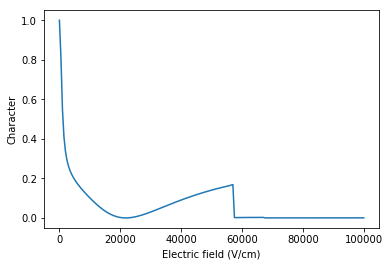

In [21]:
state = 5**2 + 6**2 + 6 
L_char = 2
print('State: \t\t n=', n_vals[state], ', l=', L_vals[state], ', m=', m_vals[state])
print('Character: \t\t l=', L_char )

eig_vec_with_char = eig_vecs[:, state, np.where(L_vals==L_char)]
plt.plot(field, np.sum( eig_vec_with_char**2, axis=2 ) )
plt.xlabel('Electric field (V/cm)')
plt.ylabel('Character')

## L character of states

State from: 		 n= 6 , l= 5 , m= 0
State to: 		 n= 7 , l= 2 , m= 0
Character: 		 l= 2


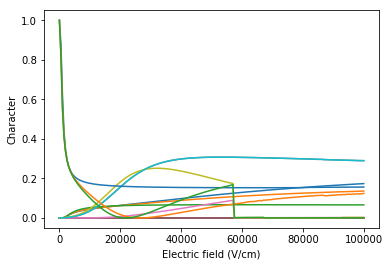

In [26]:
state_from = 5**2 + 6**2 - 6
state_to = 5**2 + 6**2 + 6
L_char = 2
print('State from: \t\t n=', n_vals[state_from], ', l=', L_vals[state_from], ', m=', m_vals[state_from])
print('State to: \t\t n=', n_vals[state_to], ', l=', L_vals[state_to], ', m=', m_vals[state_to])
print('Character: \t\t l=', L_char )

for state in np.arange(state_from, state_to+1, 1):
    eig_vec_with_char = eig_vecs[:, state, np.where(L_vals==L_char)]
    plt.plot(field, np.sum( eig_vec_with_char**2, axis=2 ) )

plt.xlabel('Electric field (V/cm)')
plt.ylabel('Character')

In [30]:
n_1, l_1, m_1 = 72, 71, 71
n_2, l_2, m_2 = 71, 70, 70
transition_dipole_moment = np.abs(
    stark_int(n_1, n_2, l_1, l_2, m_1, m_2, field_orientation='parallel', dm_allow=[-1,0,+1])) * e*a_0 # in atomic units e a_0
print('Transition dipole moment: ', transition_dipole_moment/(e*a_0), ' (a.u.)')

Transition dipole moment:  3576.83566428  (a.u.)


In [75]:
# Spontaneous decay rate
# quantum numbers
nmin = 71
nmax = 72
S = 1
m = 0
n_vals, L_vals = get_nl_vals(nmin, nmax, m)
J_vals = get_J_vals(S, L_vals, 1)
# energy levels
En = W_n(S, n_vals, L_vals, J_vals)
E_upper = En[np.intersect1d(np.where(n_vals == 55), np.where(L_vals == 54))[0]] * E_h
E_lower = En[np.intersect1d(np.where(n_vals == 54), np.where(L_vals == 53))[0]] * E_h

omega_transition = 2*pi*np.abs(E_upper - E_lower)/h # E=hf=h(w/2pi), w=2pi*E/h
einstein_A = ((2*omega_transition**3)/(3*epsilon_0*h*c**3)) * np.abs(transition_dipole_moment)**2
print('Spontaneous emission rate: ', einstein_A, ' /s')
print('Radiative lifetime, T1: ', (1/einstein_A) * 10**3, ' ms')

Spontaneous emission rate:  64.6085238915  /s
Radiative lifetime, T1:  15.4778338796  ms
